In [116]:
import numpy as np
import pandas as pd
from scipy import fftpack
from scipy import signal
import datetime
import pickle
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
WORKSPACE_PATH = '/home/takeyama/pywork/ipython/2016-06-06/'

mozartの環境設定

In [3]:
#p_path="/home/takeyama/pywork/ipython/2016-05-30/"

In [4]:
#cd ~/Documents/SyncRecord/cleaning-addingLABEL/

workstationの環境設定

In [5]:
cd ~/Documents/AddingLabel+FFTdata/

/home/takeyama/Documents/AddingLabel+FFTdata


In [6]:
class SensorData:
    
    def __init__(self):
        print "__class__"
        # raw data
        self._RawData={}    
        # fft data
        self._FFTData={}
        # power spectol data
        self._PowerData={}    
        # flag exsist data
        self._Flag_exist_data=False
        
        self._columns=['AccX','AccY','AccZ','GyrX','GyrY','GyrZ']
        self._fft_col=['fft_AccX','fft_AccY','fft_AccZ','fft_GyrX','fft_GyrY','fft_GyrZ']
        self._power_col=['power_AccX','power_AccY','power_AccZ','power_GyrX','power_GyrY','power_GyrZ']
        
    def ImportCSV(self,Sclass,csv_file):
        self.ClassName=Sclass
        self.Flag_exist_data=True
        # design dataframe
        data = pd.read_csv(csv_file,encoding="SHIFT-JIS")
        data.columns=[u'Type',u'Time',u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ']
        data.Time=pd.to_datetime(data.Time)
        data = pd.pivot_table(data,values=[u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ'],index=[u'Time'])
        
        # convert numpy.darray
        AccX=data.AccX.values*0.0001
        AccY=data.AccY.values*0.0001
        AccZ=data.AccZ.values*0.0001
        GyrX=data.GyrX.values*0.01
        GyrY=data.GyrY.values*0.01
        GyrZ=data.GyrZ.values*0.01
        Time=data.index.to_pydatetime().astype('datetime64[ns]')
        
        # regist each raw data 
        self._RawData['AccX'] = AccX
        self._RawData['AccY'] = AccY
        self._RawData['AccZ'] = AccZ
        self._RawData['GyrX'] = GyrX
        self._RawData['GyrY'] = GyrY
        self._RawData['GyrZ'] = GyrZ
        self._RawData['Time'] = Time
    
    def ShowFlagExistData(self):
        return self.Flag_exist_data
    
    def GetColumns(self):
        return self._columns
    
    def GetTime(self):
        return self._RawData['Time']

    def ShowAllDf(self):
        print 'AccX : ';print self._RawData['AccX']
        print 'AccY : ';print self._RawData['AccY']
        print 'AccZ : ';print self._RawData['AccZ']
        print 'GyrX : ';print self._RawData['GyrX']
        print 'GyrY : ';print self._RawData['GyrY']
        print 'GyrZ : ';print self._RawData['GyrZ']
        
    def _Time2Num(self,time):
        return np.where(self._RawData['Time']==np.datetime64(time) )[0][0]
    
    def ShowQuery(self,Sname,rng=[]):
        data = self._RawData[Sname]
        print Sname+':'+str( data[rng[0]:rng[1]])
            
    def _sliding_window(self,Sname,samp, overlap):
        count =0
        s =self._RawData['Time'][0]
        start=self._Time2Num(s)
        g = s+np.timedelta64(samp*10,'ms')
        goal= self._Time2Num(g)
        yield self._RawData[Sname][start:goal]
        
        add=overlap*0.01
        
        while True:
            try:
                count +=1
                s =s+np.timedelta64(samp*10,'ms')
                start=self._Time2Num(s)
                g  =s+np.timedelta64(samp*10,'ms')
                goal= self._Time2Num(g)
                yield self._RawData[Sname][start:goal]
            except StopIteration:
                print '_sliding_window StopIteration'
                break   
            except IndexError:
                print '_sliding_window IndexError'
                break  
                
# Fast Frier transaction            
    def GetFFT(self,Sfft,samp):
        return np.load(p_path+'fft/'+self.ClassName+'_'+Sfft+'_'+str(samp)+'.npz')['arr_0']
    
    def CalcFFT(self,samp,overlap=0.5):
        start = time.time()
        fft_data = np.array([])
        
        for n,f in zip( self._columns,self._fft_col):
            print 'start'+n+'->'+f
            sw = self._sliding_window(n,samp,overlap)
            while True:
                try:
                    d=sw.next()
                    fft_data = np.append(fft_data, fftpack.fft(d)[1:(samp/2)+1] )   # fftの直流成分を除くsample/2の
                except StopIteration:
                    print 'CalcFFTStopIteration'
                    fft_data = fft_data.reshape(len(fft_data)/(samp/2),(samp/2) )
                    self._FFTData[f] = fft_data
                    np.savez(p_path+'fft/'+self.ClassName+'_'+str(f)+'_'+str(samp),self._FFTData[f])
                    break   
        elapsed_time = time.time() - start
        print ("elapsed_time:{0}".format(elapsed_time)) + "[sec]"
           

# Spectol Power 
    def GetPower(self,Spower,samp):
        return np.load(p_path+'power/'+self.ClassName+'_'+Spower+'_'+str(samp)+'.npz')['arr_0']
    
    def _power(self,fft_array):
        p=lambda x,y : np.sqrt(x**2+y**2)
        power_array=np.array([])
        for vector in fft_array:
            tmp = p( np.real(vector),np.imag(vector) )
            tmp = tmp/np.sum(tmp)
            power_array = np.append(power_array,tmp)
        return power_array
        
    def CalcPower(self,samp,overlap=0.5):
        start = time.time()
        for fft_name,power_name in zip( self._fft_col, self._power_col):
            print 'start'+fft_name+'->'+power_name
            fft_data = self.GetFFT(fft_name,samp)
            power_data=self._power(fft_data)
            np.savez(p_path+'power/'+self.ClassName+'_'+power_name+'_'+str(samp),power_data)
        elapsed_time = time.time() - start
        print ("elapsed_time:{0}".format(elapsed_time)) + "[sec]"

センサーのスタート時間を求める

In [7]:
data1 = SensorData()
data2 = SensorData()
data3 = SensorData()
data4 = SensorData()
data5 = SensorData()

__class__
__class__
__class__
__class__
__class__


In [8]:
data1.ImportCSV('left_hand','Conv-left-hand-ags.csv')
data2.ImportCSV('left_leg','Conv-left-leg-ags.csv')
data3.ImportCSV('right_hand','Conv-right-hand-ags.csv')
data4.ImportCSV('right_leg','Conv-right-leg-ags.csv')
data5.ImportCSV('west','Conv-west-ags.csv')

In [9]:
time1=data1.GetTime()
time2=data2.GetTime()
time3=data3.GetTime()
time4=data4.GetTime()
time5=data5.GetTime()

In [10]:
if min(time1) < min(time2):
    MAX = min(time2)
else:
    MAX = min(time1)

if MAX < min(time3):
    MAX = min(time3)

if MAX < min(time4):
    MAX = min(time4)

if MAX < min(time5):
    MAX = min(time5)

print MAX

2016-06-10T18:06:15.877000000


Conv-から始まるファイルはすでにhh:mm:ssSSのように変換されている。
しかし、この形では四捨五入といった丸めることができない。

よって、最初のmsの状態で位置の桁を四捨五入すれば簡単に丸めることができるのではないだろうか？
試しに、値をleft-hand.csvの時刻から四捨五入して、hh:mm:ssSSの形に直してみる。

In [11]:
np.array(55844456,dtype='datetime64[ms]')

array(datetime.datetime(1970, 1, 1, 15, 30, 44, 456000), dtype='datetime64[ms]')

In [12]:
np.datetime64(55844456,'ms')

numpy.datetime64('1970-01-01T15:30:44.456')

In [13]:
round(55844456*0.1)*10

55844460.0

In [14]:
a=round(55844456*0.1)*10
np.datetime64(int(a),'ms')

numpy.datetime64('1970-01-01T15:30:44.460')

In [15]:
np.datetime64(55844456,'ms')

numpy.datetime64('1970-01-01T15:30:44.456')

CSVファイルをnumpyで読み込んでクラスのインポートと同じような動作ができるかどうかやってみる。

In [16]:
time = np.genfromtxt("left-hand.csv",delimiter=",",usecols=(1)) #時間の列だけを抽出

In [17]:
func = lambda x: int(round(x*0.1)*10)
a= map( func, time) 

t = lambda x: np.datetime64(x,'ms')
times = map(t, a)
time = np.array(times,dtype=np.datetime64)

In [18]:
time[0]

numpy.datetime64('1970-01-01T18:06:15.700')

In [19]:
np.datetime64(55844456,'ms')

numpy.datetime64('1970-01-01T15:30:44.456')

前処理クラス　時系列の統一　アルゴリズム　考案　2016-06-07

現在の作業状況の途中経過をここにメモする。
まずは、肝心の時系列だがpandasで読み込むよりnumpy.loadcsv使ったほうが正確である
しかし、この読み込み方法だと問題が１つある。それは、加速度データがなぜかよみこまれない
からである。
一番怪しいのは、マイナスとか符号が原因でエラーが起きているのではないかと考える。


In [20]:
#sampling freqency 
samp=10

サンプリング周波数を決め、切り上げ、切り捨て、四捨五入を関数を使用しないで実装してみる
この計算では各データの単位はmsで行う。
理由として、csvファイルの時刻は当日０時から経過したmsであるから

In [21]:
time = np.genfromtxt("left-hand.csv",delimiter=",",usecols=(1)) #時間の列だけを抽出

In [22]:
time

array([ 65175696.,  65175706.,  65175716., ...,  65730376.,  65730386.,
        65730396.])

In [23]:
#切り捨て
output = (time/samp).astype(int)*samp
output

array([65175690, 65175700, 65175710, ..., 65730370, 65730380, 65730390])

In [24]:
#切り上げ
output = ((time+samp)/samp).astype(int)*samp
output

array([65175700, 65175710, 65175720, ..., 65730380, 65730390, 65730400])

In [25]:
#四捨五入
output = ( (time+samp/2)/samp).astype(int)*samp
output

array([65175700, 65175710, 65175720, ..., 65730380, 65730390, 65730400])

結局、最初のデータは時間を指すことはわかるが、２番めの数字は元データをみても該当するものはない。
よって、２通りのCSV読む方法を取る。１つはpandas、もう１つはnumpy.loadtxtである。
pandasのほうでは、加速度、角速度を読み込む
numpyのほうでは、時系列を読み込む

In [26]:
'''
csv_file -> ファイル名
mode Round -> 四捨五入
     Roundup -> 切り上げ
     Rounddown -> 切り捨て
'''
def ImportCSV(csv_file,samp,mode='Round'):
        # data dictionary 
        RawData={}   
        
        # design dataframe and import csv
        data = pd.read_csv(csv_file,encoding="SHIFT-JIS")
        data.columns=[u'Type',u'Time',u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ']
        data = data[ data['Type']=='ags']
        
        # convert numpy.darray 
        # Acc Data  [0.1mG]=>[G]
        # Gyr Data  [0.01dps]=>[dps]   ...dps=degree per second
        AccX=data.AccX.values*0.0001
        AccY=data.AccY.values*0.0001
        AccZ=data.AccZ.values*0.0001
        GyrX=data.GyrX.values*0.01
        GyrY=data.GyrY.values*0.01
        GyrZ=data.GyrZ.values*0.01
        
        # regist each raw data 
        RawData['AccX'] = AccX
        RawData['AccY'] = AccY
        RawData['AccZ'] = AccZ
        RawData['GyrX'] = GyrX
        RawData['GyrY'] = GyrY
        RawData['GyrZ'] = GyrZ
        
        # import time by using numpy
        time = data.Time.values #時間の列だけを抽出       
        
        if mode == 'Roundup':
            func = lambda x: int(x/samp)*samp
        elif mode == 'Rounddown':
            func = lambda x: int(x/samp)*samp
        elif mode == 'Round':
            func = lambda x: int((x+samp/2)/samp)*samp
        #ERROR
        else:
            print 'check mode and inputed word is caused error'
            return -1
        
        output = map(func,time)
        RawData['Time'] = output
        return RawData
            

In [27]:
check1 = ImportCSV('left-hand.csv',10)

In [28]:
check1['Time'][66]

65176370

この関数を使用することによって、切り捨て切り上げ、四捨五入を行い
時系列の時間を10msごとのデータになった ->1の桁はゼロである

次に、各データの時系列を同期する

In [29]:
check2 = ImportCSV('left-leg.csv',10)
check3 = ImportCSV('right-hand.csv',10)
check4 = ImportCSV('right-leg.csv',10)
check5 = ImportCSV('west.csv',10)

センサの時系列の最小値を求める。そして、それぞれの最小値を比較して
その中で一番大きい値をスタート時間とする

In [30]:
if min(check1['Time']) < min(check2['Time']):
    MAX = min(check2['Time'])
else:
    MAX = min(check1['Time'])

if MAX < min(check3['Time']):
    MAX = min(check3['Time'])

if MAX < min(check4['Time']):
    MAX = min(check4['Time'])

if MAX < min(check5['Time']):
    MAX = min(check5['Time'])

print MAX

65175890


In [31]:
print min(check1['Time'])
print min(check2['Time'])
print min(check3['Time'])
print min(check4['Time'])
print min(check5['Time'])

65175710
65175890
65175670
65175810
65175760


センサの時系列の最大値を求める。そして、それぞれの最大値を比較して
その中で一番小さい値をスタート時間とする

In [32]:
if max(check1['Time']) < max(check2['Time']):
    MIN = max(check1['Time'])
else:
    MIN = max(check2['Time'])

if MIN > max(check3['Time']):
    MIN = max(check3['Time'])

if MIN > max(check4['Time']):
    MIN = max(check4['Time'])

if MIN > max(check5['Time']):
    MIN = max(check5['Time'])

print MIN

65730150


In [33]:
print max(check1['Time'])
print max(check2['Time'])
print max(check3['Time'])
print max(check4['Time'])
print max(check5['Time'])

65730400
65730970
65730150
65730810
65730620


各センサの時系列データをスタート時間を０番目となるようにする


In [34]:
for i in range(0, len(check1['Time'])):
    if 65175890 == check1['Time'][i]:
            print 'start index number is '+str(i)

start index number is 18


In [35]:
check1['Time'][18]

65175890

In [36]:
for i in range(0, len(check2['Time'])):
    if 65175890 == check2['Time'][i]:
            print 'start index number is '+str(i)

start index number is 0


In [37]:
check2['Time'][0]

65175890

In [38]:
for i in range(0, len(check3['Time'])):
    if 65175890 == check3['Time'][i]:
            print 'start index number is '+str(i)

start index number is 22


In [39]:
check3['Time'][22]

65175890

In [40]:
for i in range(0, len(check4['Time'])):
    if 65175890 == check4['Time'][i]:
            print 'start index number is '+str(i)

start index number is 8


In [41]:
check4['Time'][8]

65175890

In [42]:
for i in range(0, len(check5['Time'])):
    if 65175890 == check5['Time'][i]:
            print 'start index number is '+str(i)

start index number is 13


In [43]:
check5['Time'][13]

65175890

上記の方法で求めたスタート時間とゴール時間の間を扱う。
しかし、その区間にもセンサによっては取得できてない可能性もあるので確認する

手法としては、スタート時間からゴール時間をステップ+10とした連続値の配列を作成する
各センサデータの時系列はこの配列（以後、参照配列と呼称する）と比較してNANがあるかどうか調べる
NANがある場合、同じ大きさの配列のフラグにFalseを入れる。ない場合はTrueを入れる


In [44]:
ReferenceIndex = range(65175890,65730150,10)
Flag_ExistData = {}
Flag_ExistData['check1']= range(0, len(ReferenceIndex))
Flag_ExistData['check2']= range(0, len(ReferenceIndex))
Flag_ExistData['check3']= range(0, len(ReferenceIndex))
Flag_ExistData['check4']= range(0, len(ReferenceIndex))
Flag_ExistData['check5']= range(0, len(ReferenceIndex))

2016-6-8
以後、行われていることはReferenceIndexと各データcheck1-5で違う時間
をもっているかどうか
つまり、スタート時間からゴール時間のデータを各データは保持している
かどうかを調査する

In [45]:
count = 0
checkData = check1['Time']
i=0
for i in range(0, len(checkData)):
    if 65175890 == checkData[i]:
        startNum=i
        print 'start index number is '+str(i)
        break
        
if i == len(checkData)-1:
    startNum=0
    print 'start index number is '+str(0)
    
for i in range(0, len(ReferenceIndex)):
    if (checkData[i+startNum]==ReferenceIndex[i]):
        #print str(i)+' is all sensor data complete'
        Flag_ExistData['check1'][i]=True
    else:
        #print str(i)+' is data has nan data'
        Flag_ExistData['check1'][i]=False
        count +=1
print count

start index number is 18
0


In [46]:
count = 0
checkData = check2['Time']
i=0
for i in range(0, len(checkData)):
    if 65175890 == checkData[i]:
        startNum=i
        print 'start index number is '+str(i)
        break
        
if i == len(checkData)-1:
    startNum=0
    print 'start index number is '+str(0)
    
for i in range(0, len(ReferenceIndex)):
    if (checkData[i+startNum]==ReferenceIndex[i]):
        #print str(i)+' is all sensor data complete'
        Flag_ExistData['check2'][i]=True
    else:
        #print str(i)+' is data has nan data'
        Flag_ExistData['check2'][i]=False
        count +=1
print count

start index number is 0
0


In [47]:
count = 0
checkData = check3['Time']
i=0
for i in range(0, len(checkData)):
    if 65175890 == checkData[i]:
        startNum=i
        print 'start index number is '+str(i)
        break
        
if i == len(checkData)-1:
    startNum=0
    print 'start index number is '+str(0)
    
for i in range(0, len(ReferenceIndex)):
    if (checkData[i+startNum]==ReferenceIndex[i]):
        #print str(i)+' is all sensor data complete'
        Flag_ExistData['check3'][i]=True
    else:
        #print str(i)+' is data has nan data'
        Flag_ExistData['check3'][i]=False
        count +=1
print count

start index number is 22
0


In [48]:
count = 0
checkData = check4['Time']
i=0
for i in range(0, len(checkData)):
    if 65175890 == checkData[i]:
        startNum=i
        print 'start index number is '+str(i)
        break
        
if i == len(checkData)-1:
    startNum=0
    print 'start index number is '+str(0)
    
for i in range(0, len(ReferenceIndex)):
    if (checkData[i+startNum]==ReferenceIndex[i]):
        #print str(i)+' is all sensor data complete'
        Flag_ExistData['check4'][i]=True
    else:
        #print str(i)+' is data has nan data'
        Flag_ExistData['check4'][i]=False
        count +=1
print count

start index number is 8
0


In [49]:
'''
count = 0
checkData = check5['Time']
i=0
for i in range(0, len(checkData)):
    if 65175890 == checkData[i]:
        startNum=i
        print 'start index number is '+str(i)
        break
        
if i == len(checkData)-1:
    startNum=0
    print 'start index number is '+str(0)

for i in range(0, 55426):
    print checkData[i+startNum]
    if (checkData[i+startNum]==ReferenceIndex[i]):
        #print str(i)+' is all sensor data complete'
        Flag_ExistData['check5'][i]=True
    else:
        #print str(i)+' is data has nan data'
        Flag_ExistData['check5'][i]=False
        count +=1
print count
'''

"\ncount = 0\ncheckData = check5['Time']\ni=0\nfor i in range(0, len(checkData)):\n    if 65175890 == checkData[i]:\n        startNum=i\n        print 'start index number is '+str(i)\n        break\n        \nif i == len(checkData)-1:\n    startNum=0\n    print 'start index number is '+str(0)\n\nfor i in range(0, 55426):\n    print checkData[i+startNum]\n    if (checkData[i+startNum]==ReferenceIndex[i]):\n        #print str(i)+' is all sensor data complete'\n        Flag_ExistData['check5'][i]=True\n    else:\n        #print str(i)+' is data has nan data'\n        Flag_ExistData['check5'][i]=False\n        count +=1\nprint count\n"

上のアルゴリズムのについての原因を考える。原因は、check5の配列の長さが54992あるのに対して
ReferenceIndexの長さは55426である。共通区間はあくまでも各データの時系列のデータの長さより小さくなければ
共通という意味に矛盾する。つまり、ここが原因なのではないかと考える。

確認方法として、配列の前後の差を調べる。そして、差が10以外のデータのインデックスを探す

In [50]:
checkData = check1['Time']
diff =[]
diff_index=[]
for i in range(0,len(checkData)-1):
    if ( checkData[i+1]-checkData[i] )!=10:
        diff.append(checkData[i+1]-checkData[i])
        diff_index.append(i)
        print 'Error Index Num='+str(i)+' diff='+str( checkData[i+1]-checkData[i] )
        print str(i)+'s Data ='+str( checkData[i])
        print str(i+1)+'s Data ='+str( checkData[i+1])

In [51]:
checkData = check2['Time']
diff =[]
diff_index=[]
for i in range(0,len(checkData)-1):
    if ( checkData[i+1]-checkData[i] )!=10:
        diff.append(checkData[i+1]-checkData[i])
        diff_index.append(i)
        print 'Error Index Num='+str(i)+' diff='+str( checkData[i+1]-checkData[i] )
        print str(i)+'s Data ='+str( checkData[i])
        print str(i+1)+'s Data ='+str( checkData[i+1])

In [52]:
checkData = check3['Time']
diff =[]
diff_index=[]
for i in range(0,len(checkData)-1):
    if ( checkData[i+1]-checkData[i] )!=10:
        diff.append(checkData[i+1]-checkData[i])
        diff_index.append(i)
        print 'Error Index Num='+str(i)+' diff='+str( checkData[i+1]-checkData[i] )
        print str(i)+'s Data ='+str( checkData[i])
        print str(i+1)+'s Data ='+str( checkData[i+1])

In [53]:
checkData = check4['Time']
diff =[]
diff_index=[]
for i in range(0,len(checkData)-1):
    if ( checkData[i+1]-checkData[i] )!=10:
        diff.append(checkData[i+1]-checkData[i])
        diff_index.append(i)
        print 'Error Index Num='+str(i)+' diff='+str( checkData[i+1]-checkData[i] )
        print str(i)+'s Data ='+str( checkData[i])
        print str(i+1)+'s Data ='+str( checkData[i+1])

In [54]:
# zero patting
checkData = check5['Time']
diff =[]
diff_index=[]
for i in range(0,len(checkData)-1):
    if ( checkData[i+1]-checkData[i] )!=10:
        diff.append(checkData[i+1]-checkData[i])
        diff_index.append(i)
        print 'Error Index Num='+str(i)+' diff='+str( checkData[i+1]-checkData[i] )
        print str(i)+'s Data ='+str( checkData[i])
        print str(i+1)+'s Data ='+str( checkData[i+1])


Error Index Num=5589 diff=1330
5589s Data =65231650
5590s Data =65232980
Error Index Num=5650 diff=3000
5650s Data =65233580
5651s Data =65236580
Error Index Num=5813 diff=90
5813s Data =65238200
5814s Data =65238290
Error Index Num=5870 diff=430
5870s Data =65238850
5871s Data =65239280
Error Index Num=6266 diff=140
6266s Data =65243230
6267s Data =65243370
Error Index Num=6302 diff=20
6302s Data =65243720
6303s Data =65243740


In [55]:
diff

[1330, 3000, 90, 430, 140, 20]

In [56]:
diff_index

[5589, 5650, 5813, 5870, 6266, 6302]

2016-06-09

歯抜けデータがあったときの対象法２
歯抜けしたデータを別の値で埋めるというzero pattingというやり方をする。

1. diff, diff_indexに差が１０位外のときの差、その差が生じた時のインデックスを格納する。
2. diff_indexに格納されているインデックス番号までのデータをtmpに格納する
3. diff_indexに格納されている。10で割ることによって不足している要素数がわかるので、その要素数分までnanを格納する


In [57]:
import time
start_time = time.time()
       
start = 0
checkData = check5['Time']

tmp = np.array([])
for count,l in enumerate(diff_index):
    tmp = np.append(tmp, checkData[start:l])
    for i in range(0,(diff[count]/10) ):
        tmp = np.append(tmp,np.nan)
    start = l+1
tmp=np.append(tmp, checkData[start:])
print tmp
#print len(tmp)

elapsed_time = time.time() -start_time
print ("elapsed_time:{0}".format(elapsed_time)) + "[sec]"

[ 65175760.  65175770.  65175780. ...,  65730600.  65730610.  65730620.]
elapsed_time:0.020663022995[sec]


歯抜けデータがあったときの対象1

歯抜けしたインデックスを区切って別のデータとして保存

1. diff, diff_indexに差が１０位外のときの差、その差が生じた時のインデックスを格納する。
2. 1.の処理をすべてのセンサーに行う
3. diff_indexをソートする
4. diff_indexの奇数から偶数番目の区間が共通区間であるからその区間のインデックスを出す

対象法１　ステップ１　歯抜けデータのインデックス、そしてそのインデックス

ある配列に配列を加えたとき、[1,2,3],[1,3,4]にするためには
np.append( daat, np.array(), axis=0)

この関数の仕様を決める。入力データは歯抜けのあるデータとする。
さっきのアルゴリズムの4番目に追加する。
5. その区間の長さをサンプル数に応じた長さで配列を抽出する


In [58]:
samp = 8

In [59]:
len(diff_index)

6

In [60]:
diff_index[0:10]

[5589, 5650, 5813, 5870, 6266, 6302]

In [61]:
len( check5['Time'] )

54992

**2016-06-10**
***
以下のアルゴリズムについて説明する。
これのアルゴリズムの目的は、NANデータを含まないが時系列が非連続となっているデータから
連続となっている時系列を抽出し、そして抽出したデータを列(width)がサンプル数となるようにして出力する。

目的と重複してしまうが、対象とする入力、出力データは
入力データ　＝　NANデータを含まないが時系列が非連続となっているデータ
出力データ　＝　連続となっている時系列を抽出し、そして抽出したデータを列(width)がサンプル数となるデータ

アルゴリズムの流れは
ある１つの時刻データから連続となっている部分の最後をdiff_indexに格納する。また、そして格納した時間と次のインデックスの
時間の差をdiffに格納する。
diff_indexのインデックスと連続となっている部分の最初のデータを抽出する。
そして、抽出したデータをwidthをsample数にする。
気をつけるとすると、抽出したデータの要素数がサンプル数以上であることが出力する条件である。


スタート時間をもとめるプログラム

In [62]:
def ClacStartTime(array):
    MAX = min(array[0])
    
    for i in range(len(array)):
        if MAX < min(array[i]):
            MAX = min(array[i])
     
    return  MAX

In [63]:
SensorStartTime=ClacStartTime([check1['Time'],check2['Time'],check3['Time'],check4['Time'],check5['Time']])
SensorStartTime

65175890

ゴール時間をもとめるプログラム

In [64]:
def ClacGoalTime(array):
    MIN = max(array[0])
    
    for i in range(len(array)):
        if MIN > max(array[i]):
            MIN = max(array[i])
     
    return  MIN

In [65]:
SensorGoalTime=ClacGoalTime([check1['Time'],check2['Time'],check3['Time'],check4['Time'],check5['Time']])
SensorGoalTime

65730150

SensorStartTimeに定義した時間を格納した各センサの時系列のインデックスを算出する

In [66]:
def CalcSearchIndexFromTime(checkData,CompareTime):
    count = 0
    for i in range(0, len(checkData)):
        if CompareTime == checkData[i]:
            startNum=i
            print 'start index number is '+str(i)
            break
    return startNum

In [67]:
CalcSearchIndexFromTime(check2['Time'],SensorStartTime)

start index number is 0


0

In [68]:
CalcSearchIndexFromTime(check2['Time'],SensorGoalTime)

start index number is 55426


55426

diff_index,diffに時系列データからあるインデックスとその次のインデックスのデータの差が10msではないインデックス
をdiff_indexにすべて格納する。そして、その時の差をdiffに格納する。

In [69]:
def CalcDiffTimeArray(checkData):
    diff =[]
    diff_index=[]
    for i in range(0,len(checkData)-1):
        if ( checkData[i+1]-checkData[i] )!=10:
            diff.append(checkData[i+1]-checkData[i])
            diff_index.append(i)
            print 'Error Index Num='+str(i)+' diff='+str( checkData[i+1]-checkData[i] )
            print str(i)+'s Data ='+str( checkData[i])
            print str(i+1)+'s Data ='+str( checkData[i+1])
    
    return diff_index,diff

In [70]:
CalcDiffTimeArray(check1['Time'])

([], [])

In [71]:
CalcDiffTimeArray(check2['Time'])

([], [])

In [72]:
CalcDiffTimeArray(check3['Time'])

([], [])

In [73]:
CalcDiffTimeArray(check4['Time'])

([], [])

In [74]:
CalcDiffTimeArray(check5['Time'])

Error Index Num=5589 diff=1330
5589s Data =65231650
5590s Data =65232980
Error Index Num=5650 diff=3000
5650s Data =65233580
5651s Data =65236580
Error Index Num=5813 diff=90
5813s Data =65238200
5814s Data =65238290
Error Index Num=5870 diff=430
5870s Data =65238850
5871s Data =65239280
Error Index Num=6266 diff=140
6266s Data =65243230
6267s Data =65243370
Error Index Num=6302 diff=20
6302s Data =65243720
6303s Data =65243740


([5589, 5650, 5813, 5870, 6266, 6302], [1330, 3000, 90, 430, 140, 20])

与えられた配列と、差が10ms生じるインデックスとその差の変数を2つ使って連続データを抽出し、そしてサンプル数に応じた幅の変数を返す

In [75]:
def CalcWindow(checkData,diff_index,diff):
    start_time = time.time()

    start = 0    
    tmp = np.array([])
    OuputData = np.array([0]*samp)

    # researve tmp%samp
    remainder = 0

    for l in range(0,len(diff_index) ):
        tmp = np.array( checkData[start:diff_index[l]] )
        tmp = tmp[0:len(tmp)-(len(tmp)%samp)]
        tmp = tmp.reshape(len(tmp)/samp,samp)
        axis, width = tmp.shape
        
        remainder += len(tmp)%samp

        # tmp elements must be over sample num
        if tmp.size >= samp:
            for i in range( axis ):
                OuputData = np.append(OuputData,np.array(tmp[i,:]))
        start =diff_index[l]+1

    tmp = np.array( checkData[start:] )
    tmp = tmp[0:len(tmp)-(len(tmp)%samp)]
    tmp = tmp.reshape(len(tmp)/samp,samp)
    axis, width = tmp.shape
    
    remainder += len(tmp)%samp
    
    if tmp.size >= samp:
            for i in range( axis ):
                OuputData = np.append(OuputData,tmp[i,:])

    OuputData = OuputData.reshape(len(OuputData)/samp,samp)
    
    elapsed_time = time.time() -start_time
    print ("elapsed_time:{0}".format(elapsed_time)) + "[sec]"
    return OuputData

下のアルゴリズムは、時系列データからあるインデックスとその次のインデックスのデータの差が10msではないインデックス
をdiff_indexにすべて格納する。そして、その時の差をdiffに格納する。

そして、そのデータを変数を使って、非連続な時系列データから連続データを取り出す。
その方法は、そのdiff_indexの一つ前までを連続な時系列データであるとする。そして、そこまでの配列を
別の変数に格納する。そして、新たに作成した変数を列(width)をサンプル数にして、出力する変数に格納する。
また、このときのdiff_indexの値に+1をしたインデックス番号を次の連続な時系列データの区間のスタートとする。

diff_indexによって分けられた区間分の抽出が終わったら、残りをさきほど同様な流れで出力する変数に加える。

In [76]:
start_time = time.time()
       
goal = 0
start = 0
checkData = check5['Time']

Output = np.empty((0,len(diff_index)+1), int)
tmp = np.array([])
count = 0
Ouput = np.array([0]*samp)

# researve tmp%samp
remainder = 0

for l in range(0,len(diff_index) ):
    tmp = np.array( checkData[start:diff_index[l]] )
    remainder += len(tmp)%samp
    tmp = tmp[0:len(tmp)-(len(tmp)%samp)]
    tmp = tmp.reshape(len(tmp)/samp,samp)
    axis, width = tmp.shape
    print 'start='+str(start)+' diff_index='+str(diff_index[l])+' Non-Resize-element '+str(diff_index[l]-start)
    print 'axis='+str(axis)+' width='+str(width)+' All elements='+str(tmp.size)
    # tmp elements must be over sample num
    if tmp.size >= samp:
        for i in range( axis ):
            Output = np.append(Output,np.array(tmp[i,:]))
    start =diff_index[l]+1
    print '__tmp.elements '+str(tmp.size) 
    print '__Output.elements '+str(Output.size) 
    print '__Remainder '+str(remainder)   


tmp = np.array( checkData[start:] )
remainder += len(tmp)%samp
tmp = tmp[0:len(tmp)-(len(tmp)%samp)]
tmp = tmp.reshape(len(tmp)/samp,samp)
axis, width = tmp.shape
if tmp.size >= samp:
        for i in range( axis ):
            Output = np.append(Output,tmp[i,:])
            
Output = Output.reshape(len(Output)/samp,samp)
print '__tmp.elements '+str(tmp.size) 
print '__Output.elements '+str(Output.size)   
print '__Remainder '+str(remainder)   
print Output.shape
print Output
#print len(tmp)

elapsed_time = time.time() -start_time
print ("elapsed_time:{0}".format(elapsed_time)) + "[sec]"

start=0 diff_index=5589 Non-Resize-element 5589
axis=698 width=8 All elements=5584
__tmp.elements 5584
__Output.elements 5584
__Remainder 5
start=5590 diff_index=5650 Non-Resize-element 60
axis=7 width=8 All elements=56
__tmp.elements 56
__Output.elements 5640
__Remainder 9
start=5651 diff_index=5813 Non-Resize-element 162
axis=20 width=8 All elements=160
__tmp.elements 160
__Output.elements 5800
__Remainder 11
start=5814 diff_index=5870 Non-Resize-element 56
axis=7 width=8 All elements=56
__tmp.elements 56
__Output.elements 5856
__Remainder 11
start=5871 diff_index=6266 Non-Resize-element 395
axis=49 width=8 All elements=392
__tmp.elements 392
__Output.elements 6248
__Remainder 14
start=6267 diff_index=6302 Non-Resize-element 35
axis=4 width=8 All elements=32
__tmp.elements 32
__Output.elements 6280
__Remainder 17
__tmp.elements 48688
__Output.elements 54968
__Remainder 18
(6871, 8)
[[65175760 65175770 65175780 ..., 65175810 65175820 65175830]
 [65175840 65175850 65175860 ..., 6517589

***--------------計算で使用する書く計算--------------***

スタート時間をもとめるプログラム

In [77]:
def ClacStartTime(array):
    MAX = min(array[0])
    
    for i in range(len(array)):
        if MAX < min(array[i]):
            MAX = min(array[i])
     
    return  MAX

In [78]:
SensorStartTime=ClacStartTime([check1['Time'],check2['Time'],check3['Time'],check4['Time'],check5['Time']])
SensorStartTime

65175890

ゴール時間をもとめるプログラム

In [79]:
def ClacGoalTime(array):
    MIN = max(array[0])
    
    for i in range(len(array)):
        if MIN > max(array[i]):
            MIN = max(array[i])
     
    return  MIN

In [80]:
SensorGoalTime=ClacGoalTime([check1['Time'],check2['Time'],check3['Time'],check4['Time'],check5['Time']])
SensorGoalTime

65730150

SensorStartTimeに定義した時間を格納した各センサの時系列のインデックスを算出する

In [81]:
def CalcSearchIndexFromTime(checkData,CompareTime):
    count = 0
    for i in range(0, len(checkData)):
        if CompareTime == checkData[i]:
            startNum=i
            print 'start index number is '+str(i)
            break
    return startNum

In [82]:
CalcSearchIndexFromTime(check2['Time'],SensorStartTime)

start index number is 0


0

In [83]:
CalcSearchIndexFromTime(check2['Time'],SensorGoalTime)

start index number is 55426


55426

diff_index,diffに時系列データからあるインデックスとその次のインデックスのデータの差が10msではないインデックス
をdiff_indexにすべて格納する。そして、その時の差をdiffに格納する。

In [84]:
def CalcDiffTimeArray(checkData):
    diff =[]
    diff_index=[]
    for i in range(0,len(checkData)-1):
        if ( checkData[i+1]-checkData[i] )!=10:
            diff.append(checkData[i+1]-checkData[i])
            diff_index.append(i)
            print 'Error Index Num='+str(i)+' diff='+str( checkData[i+1]-checkData[i] )
            print str(i)+'s Data ='+str( checkData[i])
            print str(i+1)+'s Data ='+str( checkData[i+1])
    
    return diff_index,diff

In [85]:
CalcDiffTimeArray(check1['Time'])

([], [])

In [86]:
CalcDiffTimeArray(check2['Time'])

([], [])

In [87]:
CalcDiffTimeArray(check3['Time'])

([], [])

In [88]:
CalcDiffTimeArray(check4['Time'])

([], [])

In [89]:
CalcDiffTimeArray(check5['Time'])

Error Index Num=5589 diff=1330
5589s Data =65231650
5590s Data =65232980
Error Index Num=5650 diff=3000
5650s Data =65233580
5651s Data =65236580
Error Index Num=5813 diff=90
5813s Data =65238200
5814s Data =65238290
Error Index Num=5870 diff=430
5870s Data =65238850
5871s Data =65239280
Error Index Num=6266 diff=140
6266s Data =65243230
6267s Data =65243370
Error Index Num=6302 diff=20
6302s Data =65243720
6303s Data =65243740


([5589, 5650, 5813, 5870, 6266, 6302], [1330, 3000, 90, 430, 140, 20])

与えられた配列と、差が10ms生じるインデックスとその差の変数を2つ使って連続データを抽出し、そしてサンプル数に応じた幅の変数を返す

In [90]:
def CalcWindow(checkData,diff_index,diff):
    start_time = time.time()

    start = 0    
    tmp = np.array([])
    OuputData = np.array([0]*samp)

    # researve tmp%samp
    remainder = 0

    for l in range(0,len(diff_index) ):
        tmp = np.array( checkData[start:diff_index[l]] )
        tmp = tmp[0:len(tmp)-(len(tmp)%samp)]
        tmp = tmp.reshape(len(tmp)/samp,samp)
        axis, width = tmp.shape
        
        remainder += len(tmp)%samp

        # tmp elements must be over sample num
        if tmp.size >= samp:
            for i in range( axis ):
                OuputData = np.append(OuputData,np.array(tmp[i,:]))
        start =diff_index[l]+1

    tmp = np.array( checkData[start:] )
    tmp = tmp[0:len(tmp)-(len(tmp)%samp)]
    tmp = tmp.reshape(len(tmp)/samp,samp)
    axis, width = tmp.shape
    
    remainder += len(tmp)%samp
    
    if tmp.size >= samp:
            for i in range( axis ):
                OuputData = np.append(OuputData,tmp[i,:])

    OuputData = OuputData.reshape(len(OuputData)/samp,samp)
    
    elapsed_time = time.time() -start_time
    print ("elapsed_time:{0}".format(elapsed_time)) + "[sec]"
    return OuputData

**メインアルゴリズム windows抽出方法その２**
1. 各センサの時系列データから共通区間のスタート、ゴールを計算
2. 共通区間のスタート、ゴールの時間が各センサにあるかどうか調べ、ある場合はそのインデックスを算出する
3. 2で算出した値をインデックスに追加したインデックスから共通区間のゴールまで間が連続データか調べる。調べる方法は、あるインデックスとその次のインデックスの差に10以外の結果があるインデックスと、その差を算出する。ここでは、インデックスをdiff_index,その差をdiff_numとする。
4. 3.で算出した情報を元に連続データの区間の最後インデックスをdiff_index[i]とする。そして、スタートは最初は0だがその後はdiff_index[i-1]とする。そして、その区間の大きさはサンプル数の倍数とする。そして、その区間を配列に入れその配列の列数をサンプル数と同じ値にする。diff_indexのすべての値を以上の計算したあと、配列に残りがある場合その区間も同様な計算をする

5. **Option** 配列１つ一つをnumpyのファイルとして保存する

In [91]:
TimeArrayList = [check1['Time'],check2['Time'],check3['Time'],check4['Time'],check5['Time']]
AccXArrayList = [check1['AccX'],check2['AccX'],check3['AccX'],check4['AccX'],check5['AccX']]
AccYArrayList = [check1['AccY'],check2['AccY'],check3['AccY'],check4['AccY'],check5['AccY']]
AccZArrayList = [check1['AccZ'],check2['AccZ'],check3['AccZ'],check4['AccZ'],check5['AccZ']]
GyrXArrayList = [check1['GyrX'],check2['GyrX'],check3['GyrX'],check4['GyrX'],check5['GyrX']]
GyrYArrayList = [check1['GyrY'],check2['GyrY'],check3['GyrY'],check4['GyrY'],check5['GyrY']]
GyrZArrayList = [check1['GyrZ'],check2['GyrZ'],check3['GyrZ'],check4['GyrZ'],check5['GyrZ']]
NameArrayList = ['Sensor1','Sensor2','Sensor3','Sensor4','Sensor5']
# phase 1
SensorStartTime = ClacStartTime(TimeArrayList)
SensorGoalTime = ClacGoalTime(TimeArrayList)

for data in TimeArrayList:
# phase 2
    StartIndex = CalcSearchIndexFromTime(data,SensorStartTime)
    GoalIndex = CalcSearchIndexFromTime(data,SensorGoalTime)
# phase 3
    diffIndex, diffNum=CalcDiffTimeArray(data)
    
arrayTime=np.array([])
arrayAccX=np.array([])
arrayAccY=np.array([])
arrayAccZ=np.array([])
arrayGyrX=np.array([])
arrayGyrY=np.array([])
arrayGyrZ=np.array([])

    
for data in TimeArrayList:
# phase 4
    arrayTime = CalcWindow(data[StartIndex:GoalIndex],diffIndex,diffNum)
    print arrayTime.shape

for AccX,AccY,AccZ,GyrX,GyrY,GyrZ,Name in zip(AccXArrayList,AccYArrayList,AccZArrayList,GyrXArrayList,GyrYArrayList,GyrZArrayList,NameArrayList):
# phase 4
    arrayAccX =CalcWindow(AccX[StartIndex:GoalIndex],diffIndex,diffNum)
    arrayAccY =CalcWindow(AccY[StartIndex:GoalIndex],diffIndex,diffNum)
    arrayAccZ =CalcWindow(AccZ[StartIndex:GoalIndex],diffIndex,diffNum)
    arrayGyrX =CalcWindow(GyrX[StartIndex:GoalIndex],diffIndex,diffNum)
    arrayGyrY =CalcWindow(GyrY[StartIndex:GoalIndex],diffIndex,diffNum)
    arrayGyrZ =CalcWindow(GyrZ[StartIndex:GoalIndex],diffIndex,diffNum)
    
    axis,width = arrayAccX.shape
    for i in range(axis):
        tmpAccX=arrayAccX[i,:]
        tmpAccY=arrayAccY[i,:]
        tmpAccZ=arrayAccZ[i,:]
        tmpGyrX=arrayGyrX[i,:]
        tmpGyrY=arrayGyrY[i,:]
        tmpGyrZ=arrayGyrZ[i,:]
        window = np.vstack( (tmpAccX,tmpAccY,tmpAccZ,tmpGyrX,tmpGyrY,tmpGyrZ))
        window = window.T
        
        # phase 5
        try:
            os.mkdir( str(WORKSPACE_PATH+'window/'+Name) )
        except OSError:
            pass
        p = '/home/takeyama/pywork/ipython/2016-06-06/window/'+Name+'/'+str(i)
        np.save(p,window)
    print arrayAccX.shape
    

start index number is 18
start index number is 55444
start index number is 0
start index number is 55426
start index number is 22
start index number is 55448
start index number is 8
start index number is 55434
start index number is 13
start index number is 54944
Error Index Num=5589 diff=1330
5589s Data =65231650
5590s Data =65232980
Error Index Num=5650 diff=3000
5650s Data =65233580
5651s Data =65236580
Error Index Num=5813 diff=90
5813s Data =65238200
5814s Data =65238290
Error Index Num=5870 diff=430
5870s Data =65238850
5871s Data =65239280
Error Index Num=6266 diff=140
6266s Data =65243230
6267s Data =65243370
Error Index Num=6302 diff=20
6302s Data =65243720
6303s Data =65243740
elapsed_time:0.152168035507[sec]
(6864, 8)
elapsed_time:0.15120100975[sec]
(6864, 8)
elapsed_time:0.151808023453[sec]
(6864, 8)
elapsed_time:0.155184030533[sec]
(6864, 8)
elapsed_time:0.15158200264[sec]
(6864, 8)
elapsed_time:0.148140907288[sec]
elapsed_time:0.14862203598[sec]
elapsed_time:0.147994995117

saveしたnumpyの配列を視覚化するために、２次元配列を３次元配列に変換して見る

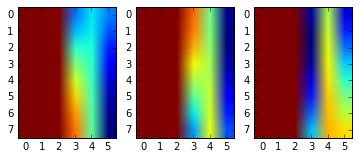

In [130]:
p = '/home/takeyama/pywork/ipython/2016-06-06/window/'+'Sensor1'+'/'+str(1)+'.npy'
l=np.load(p)
l = l*255/l.max()
plt.subplot( 131 )
plt.imshow( l )

p = '/home/takeyama/pywork/ipython/2016-06-06/window/'+'Sensor1'+'/'+str(2)+'.npy'
l=np.load(p)
l = l*255/l.max()
plt.subplot( 132 )
plt.imshow( l )

p = '/home/takeyama/pywork/ipython/2016-06-06/window/'+'Sensor1'+'/'+str(3)+'.npy'
l=np.load(p)
l = l*255/l.max()
plt.subplot( 133 )
plt.imshow( l )

In [93]:
print window

[[  1.72500000e-01  -1.17070000e+00  -2.61400000e-01  -3.15000000e+01
   -7.08300000e+01  -5.33000000e+00]
 [  1.57400000e-01  -1.18710000e+00  -2.19700000e-01  -3.78400000e+01
   -6.51100000e+01  -7.74000000e+00]
 [  1.01000000e-01  -1.14610000e+00  -1.52500000e-01  -4.59300000e+01
   -6.92100000e+01  -1.00000000e+01]
 [  7.15000000e-02  -1.15800000e+00  -2.01600000e-01  -5.15300000e+01
   -6.68000000e+01  -9.54000000e+00]
 [  4.29000000e-02  -1.12160000e+00  -2.46500000e-01  -4.92300000e+01
   -5.94000000e+01  -1.29300000e+01]
 [  5.17000000e-02  -1.11630000e+00  -2.32800000e-01  -3.85300000e+01
   -5.64200000e+01  -1.45200000e+01]
 [  5.14000000e-02  -1.11140000e+00  -2.11900000e-01  -2.92000000e+01
   -5.72000000e+01  -1.39300000e+01]
 [  3.22000000e-02  -1.10040000e+00  -1.96200000e-01  -2.17600000e+01
   -6.43100000e+01  -1.54400000e+01]]


In [94]:
print window.T

[[  1.72500000e-01   1.57400000e-01   1.01000000e-01   7.15000000e-02
    4.29000000e-02   5.17000000e-02   5.14000000e-02   3.22000000e-02]
 [ -1.17070000e+00  -1.18710000e+00  -1.14610000e+00  -1.15800000e+00
   -1.12160000e+00  -1.11630000e+00  -1.11140000e+00  -1.10040000e+00]
 [ -2.61400000e-01  -2.19700000e-01  -1.52500000e-01  -2.01600000e-01
   -2.46500000e-01  -2.32800000e-01  -2.11900000e-01  -1.96200000e-01]
 [ -3.15000000e+01  -3.78400000e+01  -4.59300000e+01  -5.15300000e+01
   -4.92300000e+01  -3.85300000e+01  -2.92000000e+01  -2.17600000e+01]
 [ -7.08300000e+01  -6.51100000e+01  -6.92100000e+01  -6.68000000e+01
   -5.94000000e+01  -5.64200000e+01  -5.72000000e+01  -6.43100000e+01]
 [ -5.33000000e+00  -7.74000000e+00  -1.00000000e+01  -9.54000000e+00
   -1.29300000e+01  -1.45200000e+01  -1.39300000e+01  -1.54400000e+01]]


In [95]:
# 2次元配列のHstackの効果
a=np.array([[0,1,2],[1,2,3]])
b=np.array([[3,4,5],[4,5,6]])

c=np.hstack((a,b))
c

array([[0, 1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5, 6]])

In [96]:
# 列指定して、転値ができるかどうか
print a[1,:]
print a.T


[1 2 3]
[[0 1]
 [1 2]
 [2 3]]


具体的なnumpyのloadtxt,genfromtxtの違い

np.loadtxt('left-hand.csv',delimiter=',',usecols=(2,3,4))

np.genfromtxt('left-hand.csv',delimiter=',',usecols=(2,3,4))